In [15]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data  import random_split, Subset
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T

import time
import copy
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torchvision.utils as vutils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from model.data_loader_gans import *

PHOTOSHOPS_FULL ='data/photoshops_resized'
ORIGINALS_FULL ='data/originals_resized'


In [17]:
master_dataset = GANsDataset(ORIGINALS_FULL, PHOTOSHOPS_FULL)
print(len(master_dataset))

20759


Change device to GPU if available

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Create train, val, splits for full learning 

This is the dataset that will be used for final learning

In [19]:
random.seed(42)

n = len(master_dataset)
n_test= int( n * .15 )  # number of test/val elements
n_val = n_test
n_train = n - 2 * n_test

train_set, val_set, test_set = random_split(master_dataset, (n_train, n_val, n_test))

In [20]:
print (len(train_set))
train_set.transform = data_transforms['train']
print (len(val_set))
val_set.transform = data_transforms['val']
print (len(test_set))
test_set.transform = data_transforms['val']

14533
3113
3113


### Create train, val, splits for dev

This is the dataset that will be used for development i.e 10% of master data

In [21]:
n_train_dev = int( n_train * .3 )
n_test_dev= int( n_test * .1 )  
n_val_dev = int( n_val * .1)


train_set_dev = Subset(train_set, range(n_train_dev))
val_set_dev = Subset(val_set,range(n_val_dev))
test_set_dev = Subset(test_set, range(n_test_dev))

In [22]:
print (len(train_set_dev))
print (len(val_set_dev))
print (len(test_set_dev))

4359
311
311


### Create data loaders for dev sets

Used to load data. 

In [23]:
full_dataloaders = {
    'train' : DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2, drop_last = True),
    'val' : DataLoader(val_set, batch_size=128, shuffle=True, num_workers=2, drop_last = True),
    'test' : DataLoader(test_set, batch_size=128, shuffle=True, num_workers=2, drop_last = True),
}



In [24]:
dev_dataloaders = {
    'train' : DataLoader(train_set_dev, batch_size=8, shuffle=True, num_workers=2, drop_last = True),
    'val' : DataLoader(val_set_dev, batch_size=8, shuffle=True, num_workers=2, drop_last = True),
    'test' : DataLoader(test_set_dev, batch_size=8, shuffle=True, num_workers=2, drop_last = True)
}

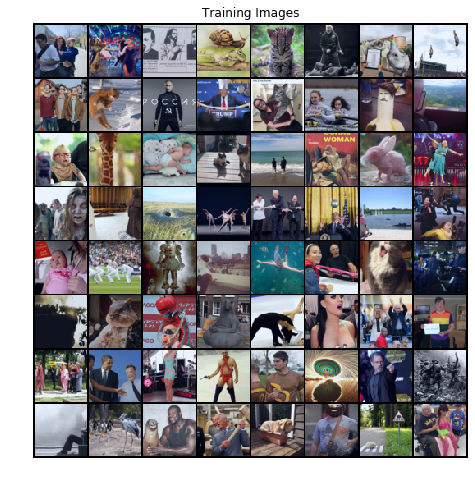

In [25]:
# Plot some training images
real_batch = next(iter(full_dataloaders['train']))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### DCGAN Implementation

In [26]:
from model.gans import *

In [27]:
netG = Generator().to(device)

In [28]:
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [29]:
netD = Discriminator().to(device)

In [30]:
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [31]:
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [33]:
(img_list, G_losses, D_losses, iters) = train_gan(netG, netD, full_dataloaders['train'], optimizerG, optimizerD)

Starting Training Loop...
[0/10][0/114]	Loss_D: 0.4608	Loss_G: 16.5767	D(x): 0.7847	D(G(z)): 0.0000 / 0.0000


OSError: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 99, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 99, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 107, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/thapelo/cs231n-project/model/data_loader_gans.py", line 95, in __getitem__
    image = Image.open(self.filenames[idx])  # PIL image
  File "/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py", line 2657, in open
    % (filename if filename else fp))
OSError: cannot identify image file '/home/thapelo/cs231n-project/model/../data/originals_resized/w1mn6.jpg'


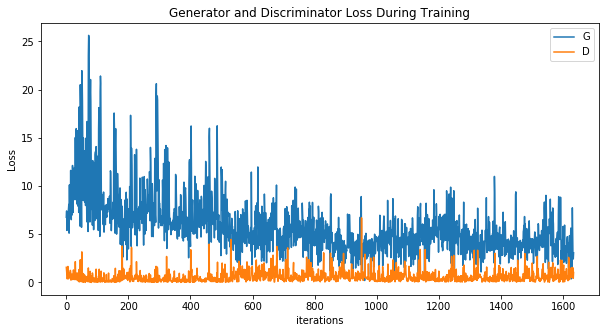

In [62]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


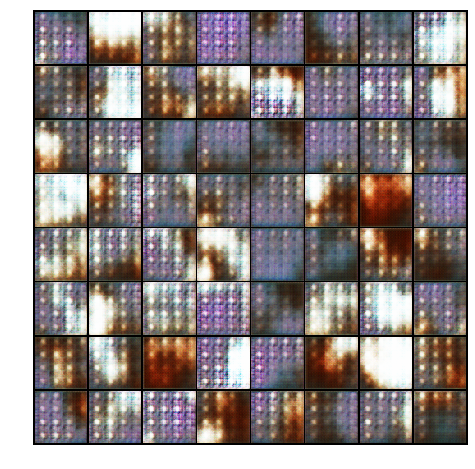

In [65]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())
